In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.pyplot as plt
import os


['addingzerototrain', 'fork-of-treebasedapproachdata', 'extremesalesclassifierfeature', 'competitive-data-science-predict-future-sales']
['__output__.json', '__results__.html', '__notebook__.ipynb', 'train_with_zero.hdf', 'custom.css']
['__output__.json', '__results___files', '__results__.html', '__notebook__.ipynb', 'DATA.hdf', 'custom.css']
['__output__.json', '__results___files', '__results__.html', '__notebook__.ipynb', 'catboost_info', 'custom.css']
['test.csv', 'item_categories.csv', 'items.csv', 'sample_submission.csv', 'sales_train.csv', 'shops.csv']


In [2]:
DATA_FPATH = '../input/fork-of-treebasedapproachdata/DATA.hdf'
TEST_LIKE_SALES_FPATH = '../input/addingzerototrain/train_with_zero.hdf'
SALES_FPATH ='../input/competitive-data-science-predict-future-sales/sales_train.csv'
ITEMS_FPATH = '../input/competitive-data-science-predict-future-sales/items.csv'
SHOPS_FPATH = '../input/competitive-data-science-predict-future-sales/shops.csv'
TEST_SALES_FPATH = '../input/competitive-data-science-predict-future-sales/test.csv'
SAMPLE_SUBMISSION_FPATH = '../input/competitive-data-science-predict-future-sales/sample_submission.csv'
TRAINED_MODEL_FPATH = 'trained_model.bin'

In [3]:
orig_sales_df = pd.read_csv(SALES_FPATH)
items_df = pd.read_csv(ITEMS_FPATH)
shops_df = pd.read_csv(SHOPS_FPATH)
test_sales_df = pd.read_csv(TEST_SALES_FPATH, index_col=0)

# Load preprocessed data.
X_df = pd.read_hdf(DATA_FPATH, 'X')
y_df = pd.read_hdf(DATA_FPATH, 'y')
val_X_10df = pd.read_hdf(DATA_FPATH, 'val_X_10')
val_y_10df = pd.read_hdf(DATA_FPATH, 'val_y_10')
val_X_9df = pd.read_hdf(DATA_FPATH, 'val_X_9')
val_y_9df = pd.read_hdf(DATA_FPATH, 'val_y_9')
columns = X_df.columns.tolist()

sales_df = pd.read_hdf(TEST_LIKE_SALES_FPATH, 'df')

In [4]:
def validation_data_asserts(val_X, val_y, val_date_block_num, sales_df, orig_sales_df):
    assert val_X.groupby(['item_id', 'shop_id'])['date_block_num'].count().shape[0] == val_X.shape[0]
    assert val_X.index.equals(val_y.index)
    assert all(val_X['date_block_num'].unique() == [val_date_block_num])

    # Ensuring that two sales df are same.
    sales_this_dbn = sales_df[sales_df.date_block_num == val_date_block_num].reset_index().groupby(
        ['item_id', 'shop_id']).agg({
            'item_cnt_day': 'sum',
            'index': 'first'
        }).reset_index().set_index('index').sort_index()
    orig_sales_this_dbn = orig_sales_df[orig_sales_df.date_block_num == val_date_block_num].reset_index().groupby(
        ['item_id', 'shop_id']).agg({
            'item_cnt_day': 'sum',
            'index': 'first'
        }).reset_index().set_index('index').sort_index()
    a = sales_this_dbn.set_index(['item_id', 'shop_id']).sort_index()
    b = orig_sales_this_dbn.set_index(['item_id', 'shop_id']).sort_index()
    assert all((a.loc[b.index] - b).item_cnt_day.unique() == [0])

    # Comparison of validation with sales_df
    sales_this_dbn.loc[sales_this_dbn.item_cnt_day > 300, 'item_cnt_day'] = 300
    sales_this_dbn.loc[sales_this_dbn.item_cnt_day < 0, 'item_cnt_day'] = 0

    assert sales_this_dbn.shape[0] == val_y.shape[0]
    assert sales_this_dbn.index.equals(val_y.sort_index().index)
    assert val_X.loc[sales_this_dbn.index, ['item_id', 'shop_id']].equals(sales_this_dbn[['item_id', 'shop_id']].astype(
        val_X[['item_id', 'shop_id']].dtypes))
    assert all((val_y - sales_this_dbn.loc[val_y.index]['item_cnt_day']).unique() == [0])


**Checks on data sanity**

In [5]:
assert X_df.shape[0] ==X_df.groupby(['item_id','shop_id','date_block_num'])['item_category_id'].count().shape[0]
validation_data_asserts(val_X_9df, val_y_9df,32,sales_df,orig_sales_df)
validation_data_asserts(val_X_10df, val_y_10df,33,sales_df,orig_sales_df)

val_X_df = pd.concat([val_X_9df,val_X_10df],sort=True)
val_y_df = pd.concat([val_y_9df,val_y_10df])
assert val_X_df.index.equals(val_y_df.index)
del val_X_9df, val_X_10df
del val_y_9df, val_y_10df

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


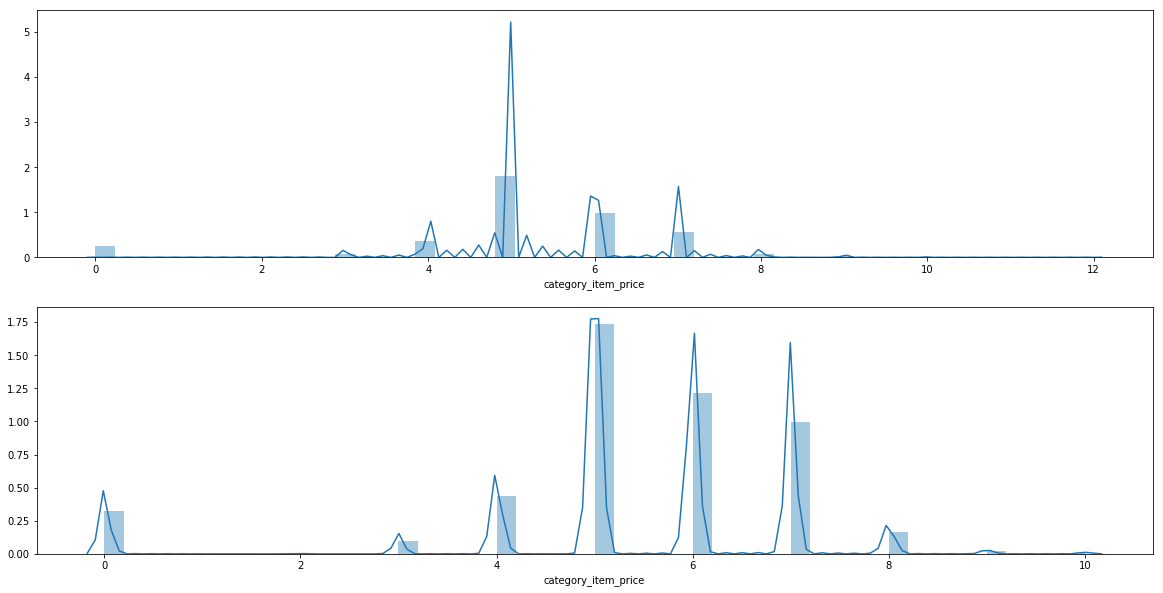

In [6]:
_, ax= plt.subplots(nrows=2, figsize=(20,10))
import seaborn as sns
sns.distplot(X_df['category_item_price'],ax=ax[0])
sns.distplot(val_X_df['category_item_price'],ax=ax[1])


**Trimming y to range [0,20]**

In [7]:
y_df[y_df > 20 ]  = 20
y_df[y_df < 0] = 0

val_y_df[val_y_df > 20] = 20
val_y_df[val_y_df < 0] = 0

In [8]:
assert val_X_df.index.equals(val_y_df.index)
assert X_df.index.equals(y_df.index)

In [9]:
gc.collect()

5

**Getting training data. it is basically prior to validation data**

In [10]:
validation_date_blocks = val_X_df.join(sales_df[[]], how='inner')['date_block_num'].unique().tolist()
print(validation_date_blocks)
min_val_dbn = min(validation_date_blocks)
X_train_df = X_df.loc[sales_df[sales_df.date_block_num < min_val_dbn].index]
y_train_df = y_df.loc[X_train_df.index]

del X_df, y_df

[32, 33]


In [11]:
gc.collect()

56

In [12]:
print(val_X_df.shape, val_y_df.shape)

(451511, 66) (451511,)


In [13]:
float64_cols = X_train_df.dtypes[X_train_df.dtypes == np.float64].index.tolist()
X_train_df[float64_cols]=X_train_df[float64_cols].astype(np.float32)
val_X_df[float64_cols]=val_X_df[float64_cols].astype(np.float32)

In [14]:
overfitted_cols = ['item_id','orig_item_id','date_block_num']
X_train_df.drop(overfitted_cols, axis=1, inplace=True)
val_X_df.drop(overfitted_cols, axis=1, inplace=True)

In [15]:
set(X_train_df.columns) - set(val_X_df.columns)

set()

In [16]:
assert set(X_train_df.columns) == set(val_X_df.columns)
val_X_df =val_X_df[X_train_df.columns]
assert val_X_df.columns.equals(X_train_df.columns)

In [17]:
X_train_df.columns

Index(['item_cnt_day_1M_sum', 'item_cnt_day_1M_min', 'item_cnt_day_1M_max',
       'item_cnt_day_1M_0.25_q', 'item_cnt_day_1M_0.5_q',
       'item_cnt_day_1M_0.75_q', 'item_cnt_day_1M_0.9_q',
       'item_cnt_day_2M_sum', 'item_cnt_day_2M_min', 'item_cnt_day_2M_max',
       'item_cnt_day_2M_0.25_q', 'item_cnt_day_2M_0.5_q',
       'item_cnt_day_2M_0.75_q', 'item_cnt_day_2M_0.9_q',
       'item_cnt_day_4M_sum', 'item_cnt_day_4M_min', 'item_cnt_day_4M_max',
       'item_cnt_day_4M_0.25_q', 'item_cnt_day_4M_0.5_q',
       'item_cnt_day_4M_0.75_q', 'item_cnt_day_4M_0.9_q', 'month', 'year',
       'shop_id', 'item_category_id', 'avg_item_price', 'last_item_price',
       'std_item_price', 'category_item_price', 'sub_category_item_price',
       'avg_category_item_price', 'avg_sub_category_item_price',
       'avg_dollar_value', 'last_dollar_value', 'std_dollar_value',
       'category_dollar_value', 'sub_category_dollar_value',
       'avg_category_dollar_value', 'avg_sub_category_dollar_va

In [18]:
del sales_df
gc.collect()

49

In [19]:
from catboost import Pool
pool_train = Pool(data=X_train_df, label=y_train_df)
pool_val = Pool(data=val_X_df, label=val_y_df)


In [20]:
from catboost import CatBoostRegressor
regressor_kwargs = {
    'depth': 11,
    'iterations':5000,
    'random_seed':0,
    'learning_rate':0.02,
    'od_type':'Iter',
    'od_wait':300,
    'task_type':'GPU',
                   }
model = CatBoostRegressor(**regressor_kwargs)

model.fit(
    pool_train,
    eval_set=pool_val,
    verbose=100,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.4665156	test: 1.1707042	best: 1.1707042 (0)	total: 107ms	remaining: 8m 55s
100:	learn: 1.0322371	test: 0.8961327	best: 0.8961327 (100)	total: 9.21s	remaining: 7m 26s
200:	learn: 0.9911803	test: 0.8900718	best: 0.8898425 (166)	total: 18s	remaining: 7m 9s
300:	learn: 0.9737304	test: 0.8867749	best: 0.8867749 (300)	total: 26.8s	remaining: 6m 58s
400:	learn: 0.9619292	test: 0.8843728	best: 0.8843728 (400)	total: 35.5s	remaining: 6m 47s
500:	learn: 0.9526819	test: 0.8823573	best: 0.8823483 (499)	total: 44.2s	remaining: 6m 36s
600:	learn: 0.9453698	test: 0.8799844	best: 0.8799844 (600)	total: 52.9s	remaining: 6m 27s
700:	learn: 0.9388250	test: 0.8784884	best: 0.8784843 (698)	total: 1m 1s	remaining: 6m 17s
800:	learn: 0.9335289	test: 0.8776224	best: 0.8776224 (800)	total: 1m 10s	remaining: 6m 8s
900:	learn: 0.9286205	test: 0.8762779	best: 0.8762779 (900)	total: 1m 19s	remaining: 6m
1000:	learn: 0.9243555	test: 0.8757502	best: 0.8756618 (993)	total: 1m 27s	remaining: 5m 51s
1100:	l

Text(0.5, 0, 'importance')

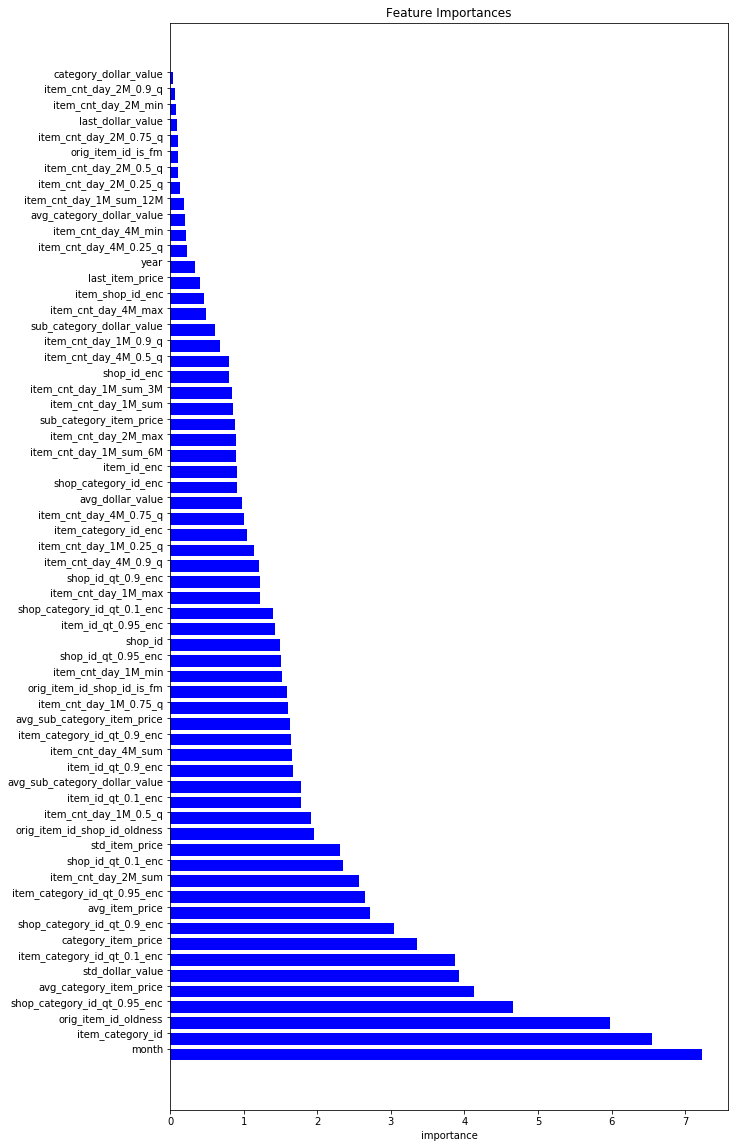

In [21]:
importances = model.get_feature_importance(prettified=True)
x = np.array(list(range(len(importances))))
y = [imp for (_,imp) in importances]
my_xticks = [col for (col,_) in importances]
fig, ax = plt.subplots(figsize=(10,20))    
width = 0.75 # the width of the bars 
ax.barh(x, y, width, color="blue")
ax.set_yticks(x+width/2)
ax.set_yticklabels(my_xticks, minor=False)
plt.title('Feature Importances')
plt.xlabel('importance')


In [22]:
pred_val_y_df = pd.Series(model.predict(pool_val),index=val_X_df.index)
pred_val_y_df[pred_val_y_df>20] = 20
pred_val_y_df[pred_val_y_df<0] = 0

In [23]:
pred_val_y_df = pred_val_y_df.to_frame('prediction')

In [24]:
pred_val_y_df['actual'] = val_y_df
pred_val_y_df.loc[pred_val_y_df.actual > 20,'actual'] = 20

In [25]:
pred_val_y_df['error'] = (pred_val_y_df['actual'] - pred_val_y_df['prediction'])
pred_val_y_df['abs_error'] = pred_val_y_df['error'].abs()
pred_val_y_df['squared_error'] = pred_val_y_df['error'].pow(2)

In [26]:
error_df = pred_val_y_df.groupby('actual').describe().swaplevel(axis=1)[['count','mean','50%','75%']]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


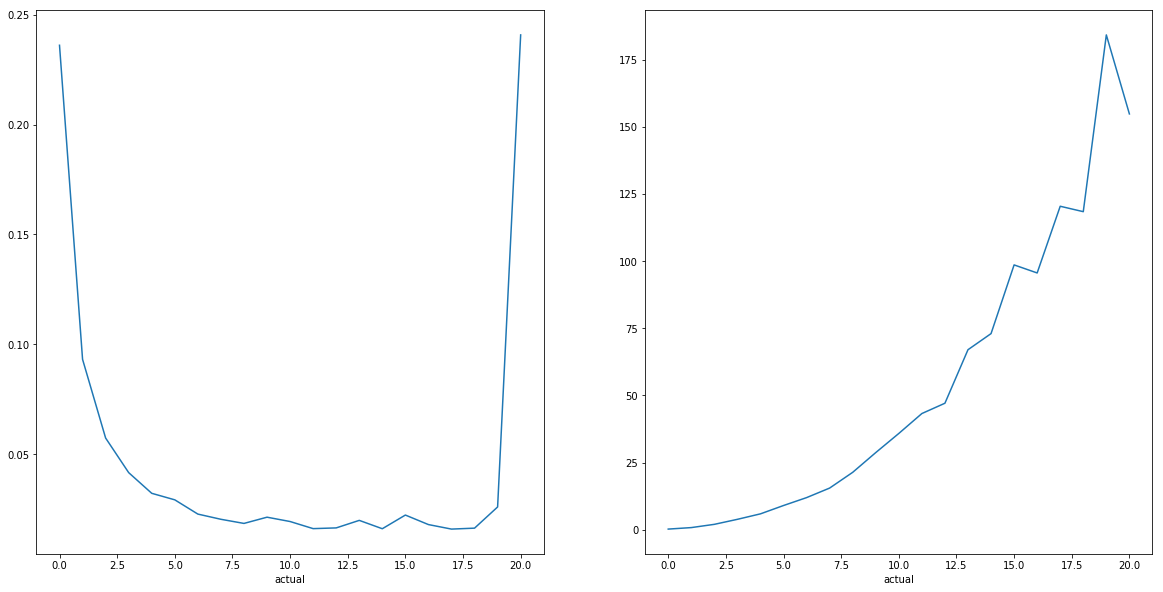

In [27]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
col = 'mean'
e_df = error_df[col]
e_df['sum_se'] = e_df['squared_error']*error_df['count']['squared_error']
(e_df['sum_se']/e_df['sum_se'].sum()).plot(ax=ax[0])
e_df['squared_error'].plot(ax=ax[1])

**We see that error is more on extremes.**

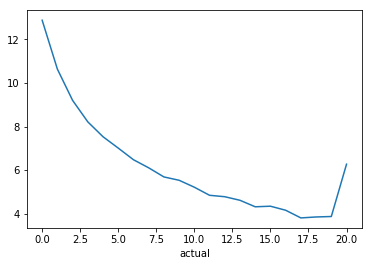

In [28]:
error_df['count']['error'].apply(np.log).plot()

In [29]:
pred_val_y_df[pred_val_y_df.actual ==1].error.describe()

count    41479.000000
mean         0.322047
std          0.812492
min        -14.491718
25%          0.157287
50%          0.566778
75%          0.781661
max          1.000000
Name: error, dtype: float64

More zeros are getting predicted. One can say it as we see that in general, the actual is more than what is predicted.

In [30]:
pred_val_y_df[pred_val_y_df.actual ==20].error.describe()

count    529.000000
mean      10.862776
std        6.071481
min        0.000000
25%        6.378568
50%       12.014382
75%       15.868983
max       19.957596
Name: error, dtype: float64

In [31]:
val_X_10df = pd.read_hdf(DATA_FPATH,'val_X_10')
val_X_9df = pd.read_hdf(DATA_FPATH,'val_X_9')
val_id_df = pd.concat([val_X_9df,val_X_10df],sort=True)
del val_X_10df,val_X_9df
assert val_id_df.index.equals(pred_val_y_df.index)

pred_val_y_df['item_id'] = val_id_df['item_id']
pred_val_y_df['shop_id'] = val_id_df['shop_id']
pred_val_y_df['item_category_id'] = val_id_df['item_category_id']
pred_val_y_df['item_category_id'] = val_id_df['item_category_id']
pred_val_y_df['orig_item_id_oldness']=val_id_df['orig_item_id_oldness']

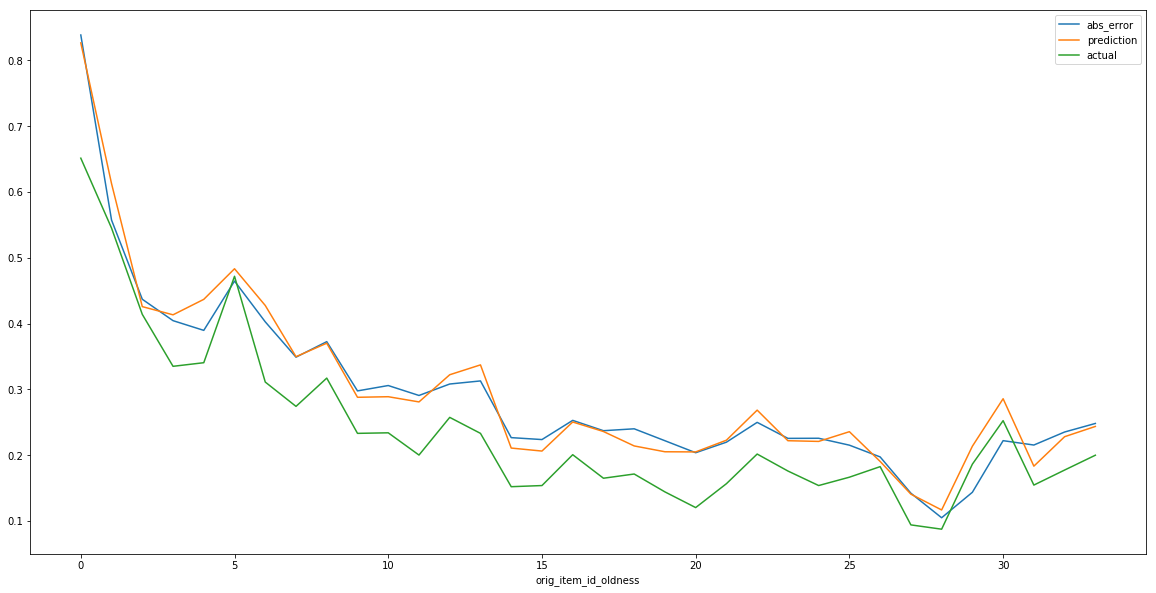

In [32]:
_,ax = plt.subplots(figsize=(20,10))
pred_val_y_df.groupby('orig_item_id_oldness')['abs_error','prediction','actual'].mean().plot(ax=ax)

**New items have high error as well as high value**

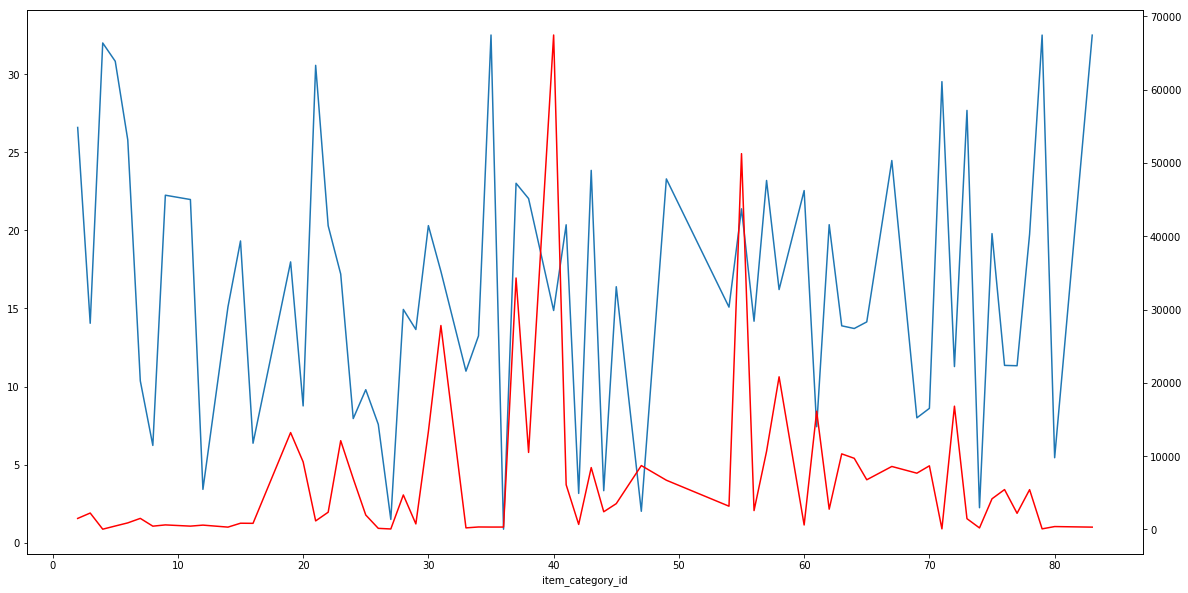

In [33]:
_, ax = plt.subplots(figsize=(20,10))
ax1 = ax.twinx()
pred_val_y_df.groupby('item_category_id')['orig_item_id_oldness'].describe()['mean'].plot(ax=ax)
pred_val_y_df.groupby('item_category_id')['orig_item_id_oldness'].describe()['count'].plot(ax=ax1,c='r')

In [34]:
pred_val_y_df.head()

,prediction,actual,error,abs_error,squared_error,item_id,shop_id,item_category_id,orig_item_id_oldness
index,,,,,,,,,
2831747,0.152186,1.0,0.847814,0.847814,0.718788,11170,42,37,28
2831750,0.549476,3.0,2.450524,2.450524,6.005070,11215,42,40,2
2831751,0.150759,1.0,0.849241,0.849241,0.721210,11232,42,37,32
2831753,0.609829,1.0,0.390171,0.390171,0.152233,11253,42,37,5
2831755,0.325834,1.0,0.674166,0.674166,0.454500,11259,42,40,9


In [35]:
pred_val_y_df.head()

,prediction,actual,error,abs_error,squared_error,item_id,shop_id,item_category_id,orig_item_id_oldness
index,,,,,,,,,
2831747,0.152186,1.0,0.847814,0.847814,0.718788,11170,42,37,28
2831750,0.549476,3.0,2.450524,2.450524,6.005070,11215,42,40,2
2831751,0.150759,1.0,0.849241,0.849241,0.721210,11232,42,37,32
2831753,0.609829,1.0,0.390171,0.390171,0.152233,11253,42,37,5
2831755,0.325834,1.0,0.674166,0.674166,0.454500,11259,42,40,9


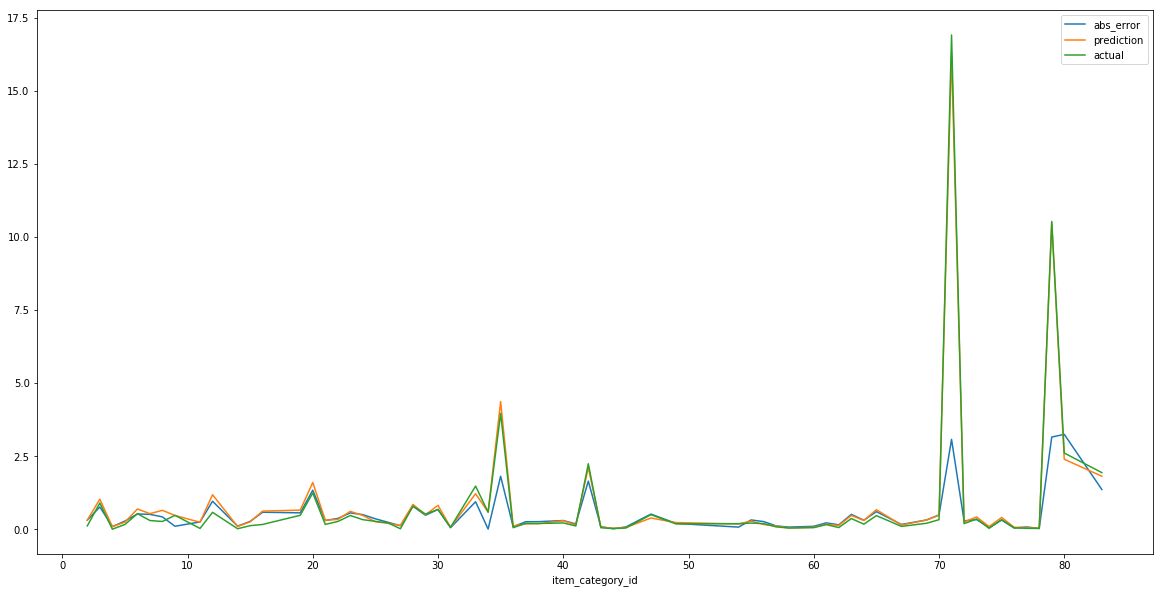

In [36]:
_,ax= plt.subplots(figsize=(20,10))
pred_val_y_df.groupby('item_category_id')['abs_error','prediction','actual'].mean().plot(ax=ax)

In [37]:
train_columns = X_train_df.columns.tolist()
del X_train_df
del pool_train
del pool_val

In [38]:
gc.collect()

7

## Retraining with whole data and predicting on test.

In [39]:
X_df = pd.read_hdf(DATA_FPATH,'X')
y_df = pd.read_hdf(DATA_FPATH, 'y')

y_df[y_df > 20] = 20
y_df[y_df < 0] = 0

assert X_df.index.equals(y_df.index)
X_df[float64_cols]=X_df[float64_cols].astype(np.float32)
X_df = X_df[train_columns]
pool_whole = Pool(data=X_df,label=y_df)


In [40]:
model.tree_count_

3516

In [41]:
regressor_kwargs['iterations'] = model.tree_count_
model = CatBoostRegressor(**regressor_kwargs)

model.fit(
    pool_whole,      
    verbose=100,
    plot=True,
)
del pool_whole
del X_df,y_df

gc.collect()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.4516253	total: 99.8ms	remaining: 5m 50s
100:	learn: 1.0256006	total: 8.95s	remaining: 5m 2s
200:	learn: 0.9852804	total: 17.6s	remaining: 4m 51s
300:	learn: 0.9685611	total: 26.2s	remaining: 4m 39s
400:	learn: 0.9571432	total: 34.7s	remaining: 4m 29s
500:	learn: 0.9484457	total: 43.2s	remaining: 4m 20s
600:	learn: 0.9409873	total: 51.7s	remaining: 4m 10s
700:	learn: 0.9346453	total: 1m	remaining: 4m 1s
800:	learn: 0.9292683	total: 1m 8s	remaining: 3m 52s
900:	learn: 0.9242714	total: 1m 17s	remaining: 3m 44s
1000:	learn: 0.9199568	total: 1m 25s	remaining: 3m 35s
1100:	learn: 0.9161220	total: 1m 34s	remaining: 3m 27s
1200:	learn: 0.9125323	total: 1m 43s	remaining: 3m 19s
1300:	learn: 0.9092831	total: 1m 51s	remaining: 3m 10s
1400:	learn: 0.9061593	total: 2m	remaining: 3m 1s
1500:	learn: 0.9032532	total: 2m 9s	remaining: 2m 53s
1600:	learn: 0.9003007	total: 2m 17s	remaining: 2m 44s
1700:	learn: 0.8976965	total: 2m 26s	remaining: 2m 36s
1800:	learn: 0.8953309	total: 2m 35s	rema

14

In [46]:
model.save_model(TRAINED_MODEL_FPATH)

In [42]:
test_X_df = pd.read_hdf(DATA_FPATH, 'test_X')
sample_submissions_df = pd.read_csv(SAMPLE_SUBMISSION_FPATH, index_col=0)

orig_test_X_df = test_X_df.copy()


assert test_X_df[orig_test_X_df.columns].equals(orig_test_X_df)
del orig_test_X_df

test_X_df[float64_cols] = test_X_df[float64_cols].astype(np.float32)
test_X_df = test_X_df[train_columns]

test_X_df = test_X_df.loc[sample_submissions_df.index,:]
test_prediction = model.predict(Pool(data=test_X_df))
test_prediction[test_prediction > 20] = 20
test_prediction[test_prediction < 0]  = 0
sample_submissions_df['item_cnt_month'] = test_prediction

In [43]:
importances = model.get_feature_importance(prettified=True)
print(importances)

[('month', 6.94165246649786), ('item_category_id', 6.577336922115016), ('orig_item_id_oldness', 6.026055666287588), ('shop_category_id_qt_0.95_enc', 4.639381090164914), ('avg_category_item_price', 4.450237071911196), ('std_dollar_value', 4.006234088923028), ('item_category_id_qt_0.1_enc', 3.9952749595540435), ('shop_category_id_qt_0.9_enc', 2.996975061313453), ('category_item_price', 2.9249077893002964), ('item_category_id_qt_0.95_enc', 2.6723037833854595), ('avg_item_price', 2.6505950992666585), ('item_cnt_day_2M_sum', 2.475458443794579), ('std_item_price', 2.3013573433534904), ('shop_id_qt_0.1_enc', 2.258979958007004), ('item_cnt_day_1M_0.5_q', 1.9613193575438086), ('orig_item_id_shop_id_oldness', 1.8476708849643952), ('item_cnt_day_4M_sum', 1.7623964742860125), ('item_id_qt_0.1_enc', 1.7168156041646658), ('avg_sub_category_dollar_value', 1.6813806951066668), ('item_id_qt_0.9_enc', 1.6566531882653495), ('item_category_id_qt_0.9_enc', 1.6046039834449817), ('orig_item_id_shop_id_is_fm'

In [44]:
sample_submissions_df.to_csv('submission.csv')

In [45]:
sample_submissions_df.head()

,item_cnt_month
ID,
0,0.636833
1,0.563139
2,0.882058
3,0.532952
4,3.898201
